Based on tutorial: https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d 
This code is focused on spanish tweets as the preprocessing to remove stopwords was configure for that

# Import packages

In [1]:
from textblob import TextBlob
#import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import os
import nltk
import re
#import string

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Config display 
pd.set_option('display.max_colwidth', None)

# Authentication credentials 

In [3]:
# Your API credentials
consumerKey = input("consumerKey: ")
consumerSecret = input("consumerSecret: ")
accessToken = input("accessToken: ")
accessTokenSecret = input("accessTokenSecret: ")


auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

# Getting Tweets

In [4]:
nltk.downloader.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/natashadiaz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natashadiaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
#Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)
keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))
tweets = tweepy.Cursor(api.search_tweets, q=keyword).items(noOfTweet)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
for tweet in tweets:
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score["neg"]
    neu = score["neu"]
    pos = score["pos"]
    comp = score["compound"]
    polarity += analysis.sentiment.polarity
    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1

    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1

    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, ".1f")
negative = format(negative, ".1f")
neutral = format(neutral, ".1f")

In [6]:
# Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  162
positive number:  6
negative number:  22
neutral number:  134


In [7]:
tweet_list.loc[1]

0    #CostaRica El nuevo presidente RodrigoChaves enfrenta al “intocable” diario La Nación por mentir. #Reporto… https://t.co/HDMByqQsoU
Name: 1, dtype: object

# Data prep

In [8]:
# Cleaning
tweet_list.drop_duplicates(inplace = True)

In [9]:
# Cleaning Text (RT, Punctuation etc)
# Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]
# Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

,0,text
0,(@CDNN23Nicaragua) #CostaRica El nuevo presidente RodrigoChaves enfrenta al “intocable” diario La Nación por mentir… https://t.co/qdqHa3LctT,costarica el nuevo presidente rodrigochaves enfrenta al intocable diario la naci n por mentir
1,#CostaRica El nuevo presidente RodrigoChaves enfrenta al “intocable” diario La Nación por mentir. #Reporto… https://t.co/HDMByqQsoU,costarica el nuevo presidente rodrigochaves enfrenta al intocable diario la naci n por mentir reporto
2,"Entonces:\n¿Los ""periodistas"" quieren gobernar?\n¡ASCO me dan!\n#CostaRica #rodrigochaves",entonces los periodistas quieren gobernar asco me dan costarica rodrigochaves
3,En mis rrss que esperaban ¿que no criticara a #RodrigoChaves? Duh obvio si con mayor razón 🧐,en mis rrss que esperaban que no criticara a rodrigochaves duh obvio si con mayor raz n
4,"#RodrigoChaves En 1748 El Barón de Montesquieu identificó 3 poderes ( legislativo, ejecutivo, judicial) pero hoy dí… https://t.co/IGZqyDU70H",rodrigochaves en 1748 el bar n de montesquieu identific 3 poderes legislativo ejecutivo judicial pero hoy d
5,"⭐️ LIMPIEZA profesional 💥\n\n- elimina sarro, placa y manchas extrínsecas\n- pulido y alisado dental\n- aplicación de f… https://t.co/petvNEX1Em",limpieza profesional elimina sarro placa y manchas extr nsecas pulido y alisado dental aplicaci n de f
6,“Se vendió como incidente lo que es una crisis”: Gobierno critica falta de transparencia de antecesor ante hackeos.… https://t.co/x1E2laj34z,se vendi como incidente lo que es una crisis gobierno critica falta de transparencia de antecesor ante hackeos
7,"Cyber attack on Costa Rica grows as more agencies hit, president says #Chaves #Alvarado #RodrigoChaves #CostaRica… https://t.co/0lBo7GT1Hl",cyber attack on costa rica grows as more agencies hit president says chaves alvarado rodrigochaves costarica
8,Cyber Gang Threatens to Overthrow Costa Rica Government\nRead More: https://t.co/o01ehBECz7 \n\n#BreakingNews… https://t.co/kjk2EQjAmc,cyber gang threatens to overthrow costa rica government read more breakingnews
9,El proyecto de ley eliminaría las juntas directivas y crearía consejos consultivos sin salarios\n@Natdiaquin… https://t.co/Cmkw02AfBV,el proyecto de ley eliminar a las juntas directivas y crear a consejos consultivos sin salarios


In [10]:
# Calculating Negative, Positive, Neutral and Compound values
tw_list[["polarity", "subjectivity"]] = tw_list["text"].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list["text"].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score["neg"]
    neu = score["neu"]
    pos = score["pos"]
    comp = score["compound"]
    if neg > pos:
        tw_list.loc[index, "sentiment"] = "negative"
    elif pos > neg:
        tw_list.loc[index, "sentiment"] = "positive"
    else:
        tw_list.loc[index, "sentiment"] = "neutral"
        tw_list.loc[index, "neg"] = neg
        tw_list.loc[index, "neu"] = neu
        tw_list.loc[index, "pos"] = pos
        tw_list.loc[index, "compound"] = comp
tw_list.head(10)

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,(@CDNN23Nicaragua) #CostaRica El nuevo presidente RodrigoChaves enfrenta al “intocable” diario La Nación por mentir… https://t.co/qdqHa3LctT,costarica el nuevo presidente rodrigochaves enfrenta al intocable diario la naci n por mentir,0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,#CostaRica El nuevo presidente RodrigoChaves enfrenta al “intocable” diario La Nación por mentir. #Reporto… https://t.co/HDMByqQsoU,costarica el nuevo presidente rodrigochaves enfrenta al intocable diario la naci n por mentir reporto,0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,"Entonces:\n¿Los ""periodistas"" quieren gobernar?\n¡ASCO me dan!\n#CostaRica #rodrigochaves",entonces los periodistas quieren gobernar asco me dan costarica rodrigochaves,0.0,0.0,neutral,0.0,1.0,0.0,0.0
3,En mis rrss que esperaban ¿que no criticara a #RodrigoChaves? Duh obvio si con mayor razón 🧐,en mis rrss que esperaban que no criticara a rodrigochaves duh obvio si con mayor raz n,-0.3,0.6,negative,NaN,NaN,NaN,NaN
4,"#RodrigoChaves En 1748 El Barón de Montesquieu identificó 3 poderes ( legislativo, ejecutivo, judicial) pero hoy dí… https://t.co/IGZqyDU70H",rodrigochaves en 1748 el bar n de montesquieu identific 3 poderes legislativo ejecutivo judicial pero hoy d,0.0,0.0,neutral,0.0,1.0,0.0,0.0
5,"⭐️ LIMPIEZA profesional 💥\n\n- elimina sarro, placa y manchas extrínsecas\n- pulido y alisado dental\n- aplicación de f… https://t.co/petvNEX1Em",limpieza profesional elimina sarro placa y manchas extr nsecas pulido y alisado dental aplicaci n de f,0.0,0.0,neutral,0.0,1.0,0.0,0.0
6,“Se vendió como incidente lo que es una crisis”: Gobierno critica falta de transparencia de antecesor ante hackeos.… https://t.co/x1E2laj34z,se vendi como incidente lo que es una crisis gobierno critica falta de transparencia de antecesor ante hackeos,0.0,0.0,negative,NaN,NaN,NaN,NaN
7,"Cyber attack on Costa Rica grows as more agencies hit, president says #Chaves #Alvarado #RodrigoChaves #CostaRica… https://t.co/0lBo7GT1Hl",cyber attack on costa rica grows as more agencies hit president says chaves alvarado rodrigochaves costarica,0.5,0.5,negative,NaN,NaN,NaN,NaN
8,Cyber Gang Threatens to Overthrow Costa Rica Government\nRead More: https://t.co/o01ehBECz7 \n\n#BreakingNews… https://t.co/kjk2EQjAmc,cyber gang threatens to overthrow costa rica government read more breakingnews,0.5,0.5,negative,NaN,NaN,NaN,NaN
9,El proyecto de ley eliminaría las juntas directivas y crearía consejos consultivos sin salarios\n@Natdiaquin… https://t.co/Cmkw02AfBV,el proyecto de ley eliminar a las juntas directivas y crear a consejos consultivos sin salarios,0.0,0.0,negative,NaN,NaN,NaN,NaN


In [11]:
# Function to Create Wordcloud
def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    #stopwords = set(STOPWORDS) # in english
    stopwords_sp = set(stopwords.words('spanish')) # in spanish
    wc = WordCloud(background_color="white",
    mask = mask,
    max_words=3000,
    stopwords=stopwords_sp,
    repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))


Word Cloud Saved Successfully


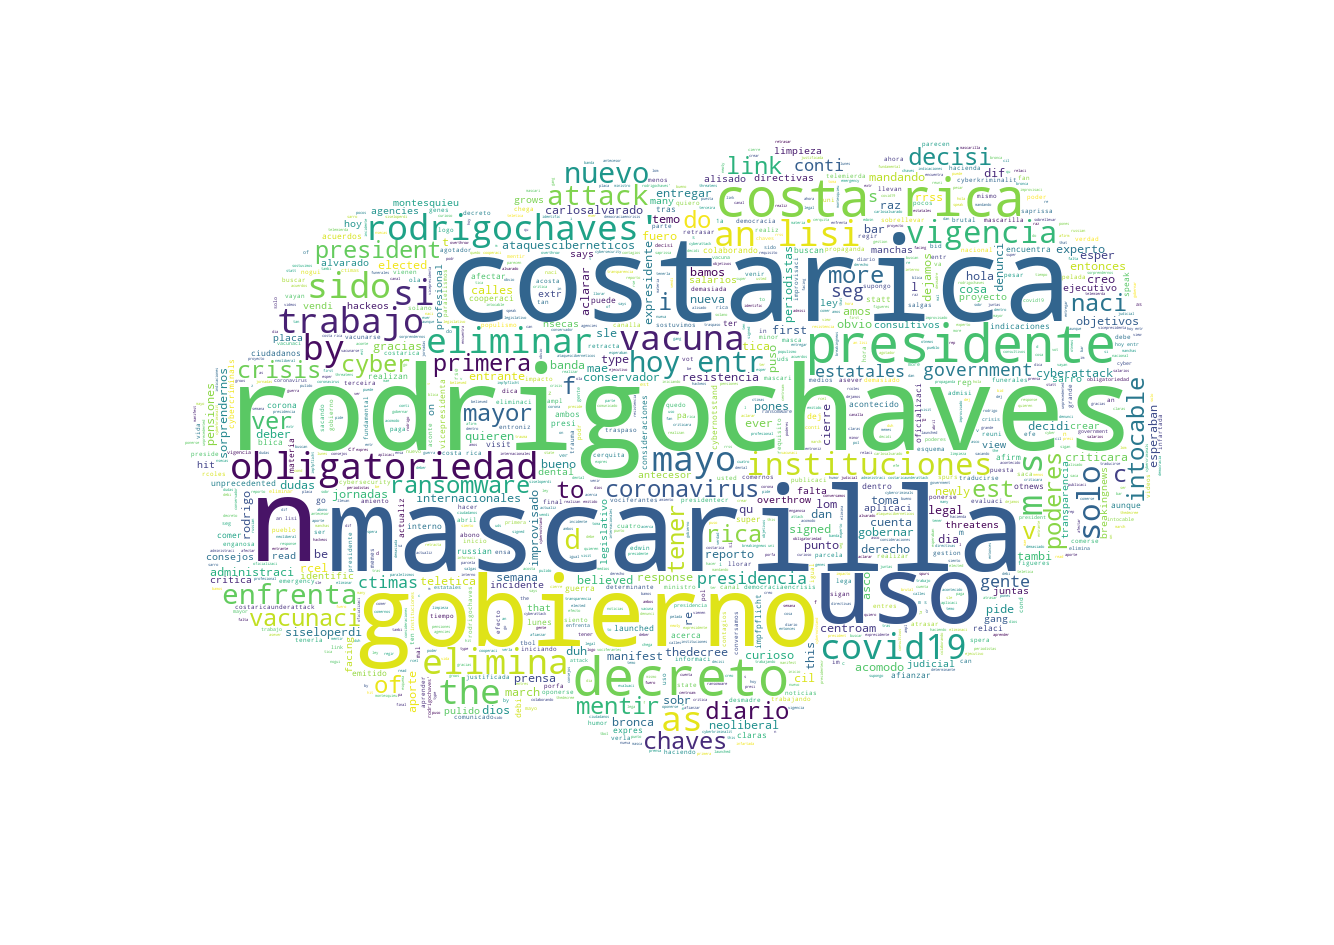

In [12]:
# Creating wordcloud for all tweets
create_wordcloud(tw_list["text"].values)